In [22]:
import scipy
import warnings
import cv2 as cv
import numpy as np 
import pandas as pd
import os, glob, torch
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch_geometric.nn import GCNConv
from seaborn import heatmap, color_palette
from sklearn.model_selection import train_test_split
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from sklearn.metrics import confusion_matrix, classification_report
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
warnings.filterwarnings('ignore')

In [23]:
def create_image_chunks(img_path):
    #open the image and convert to gray scale-> Covert 3 chaneel image(red,green,blue) to one channal with The intensity ranges from 0 (black) to 255 (white)
    img = Image.open(img_path).convert('L')

    # image is resized to dimensions of 100x100 pixels 
    img = img.resize((100, 100))

    # image is converted to a NumPy array 
    img = np.array(img)

    #image pixel values are normalized by dividing each pixel value by 255. This operation scales the pixel values to the range of [0, 1]
    img = img / 255.0

    # Split the image into 10x10 chunks (100)

    #empty list is created to store the image chunks.
    chunks = []

    #The two nested loops iterate over the rows and columns of the image, splitting it into 10x10 chunks.
    #img.shape[0] and img.shape[1] return the height and width of the image, respectively.
    #After the loops complete, the chunks list will contain 100 (10x10) chunks, each representing a 10x10 portion of the original image.
    for i in range(0, img.shape[0], 10):
        for j in range(0, img.shape[1], 10):
            chunk = img[i:i+10, j:j+10]
            chunks.append(chunk)

    return chunks

#function calculates the Pearson correlation coefficient between two arrays C1 and C2. 
#The Pearson correlation coefficient measures the linear correlation between two sets of data.
def correlationCoefficient(C1, C2):

    #returns the number of elements in the array C1
    n = C1.size

    #calculate the sum of all elements in arrays C1 and C2, respectively.
    sum_C1 = C1.sum()
    sum_C2 = C2.sum()

    #(C1 * C2) performs element-wise multiplication between C1 and C2, resulting in a new array where each element is the product of the corresponding elements in C1 and C2.
    #(C1 * C2).sum() calculates the sum of all elements in the new array, and the result is stored in the variable sum_C12.
    sum_C12 = (C1*C2).sum()
    squareSum_C1 = (C1*C1).sum()
    squareSum_C2 = (C2*C2).sum()

    #calculate peason correlation
    corr = (n * sum_C12 - sum_C1 * sum_C2)/(np.sqrt((n * squareSum_C1 - sum_C1 * sum_C1)* (n * squareSum_C2 - sum_C2 * sum_C2))) 
    return corr


def get_pearson_correlation(chunks):

    #np.zeros function from the NumPy library is used to create an array filled with zeros of the specified shape.
    corr_matrix = np.zeros((len(chunks), len(chunks)))

    #This starts a nested loop where i and j iterate over the indices of chunks. The loop is used to calculate the Pearson correlation between 
    # each pair of elements in the chunks list.
    for i in range(len(chunks)):
        for j in range(len(chunks)):
            corr_matrix[i][j] = correlationCoefficient(chunks[i], chunks[j])

    #This matrix represents the correlation values between all combinations of elements in the chunks list.        
    return corr_matrix

def adj2graph(adj):

    # converts the input adj adjacency matrix into a Compressed Sparse Row (CSR) matrix format using the scipy.
    # sparse.coo_matrix function. The CSR format is a memory-efficient way to store sparse matrices.
    coo_adj = scipy.sparse.coo_matrix(adj)

    #The function returns two values: edge_index and edge_weight.
    #edge_index: This represents the edge connections in the graph.It's typically a 2D array where each column represents a pair of nodes
    #  (source node and destination node) connected by an edge.
    #edge_weight: This represents the weight associated with each edge in the graph. It's typically a 1D array that contains the
    #  weight for each corresponding edge in the edge_index.
    edge_index, edge_weight = from_scipy_sparse_matrix(coo_adj)
    return edge_index, edge_weight

def image2graph(img_path):
    chunks = create_image_chunks(img_path)
    corr_matrix = get_pearson_correlation(chunks)

    #calculates the average correlation coefficient (avg_corr) from the corr_matrix using NumPy's np.mean function.
    avg_corr = np.mean(corr_matrix)

    #In these lines, the function applies a thresholding step to the correlation matrix. 
    # All correlation values less than the average correlation (avg_corr) are set to 0, and all correlation values greater than or equal to the average correlation are set to 1. This thresholding effectively converts the 
    # correlation matrix into a binary adjacency matrix where 1 indicates a strong correlation between chunks, and 0 indicates a weak or no correlation
    corr_matrix[corr_matrix < avg_corr] = 0
    corr_matrix[corr_matrix >= avg_corr] = 1

    # create chunk nodes as sum of all pixels in the chunk

    # It calculates the sum of all pixel values in each chunk and stores them in a NumPy array called node_features.
    # This step is essential because it's a way to represent the characteristics or properties of each node (chunk) in the graph

    #Image Chunk Size: Each chunk is a 10x10 portion of the original image.

    #Pixel Intensity: In a grayscale image, each pixel is represented by a single intensity value ranging from 0 (black) to 255 (white). 
    # In the context of your code, it looks like the image is already converted to grayscale, so each pixel intensity value represents how 
    # "bright" that pixel is.

    #Sum of Pixel Intensities: When you calculate the sum of pixel intensities within a 10x10 chunk, you're simply adding up all the individual 
    # intensity values within that chunk. This sum will be a single value that captures the overall intensity content of that specific 10x10 region
    # in the grayscale image.
    # The np.expand_dims function is then used to add an extra dimension to the array to make it suitable for representing node features in the graph.
    node_features = np.array([np.sum(chunk) for chunk in chunks])
    node_features = np.expand_dims(node_features, axis=-1)
    
    #print("Node features" , node_features)
    edge_index = adj2graph(corr_matrix)[0]
    #print("Edge Index" , edge_index) 
    return edge_index, node_features


def create_dataset(data_dir = 'data/'):
    all_files = glob.glob(f'{data_dir}*/*.*')
    all_edge_index, all_node_features, all_labels = [], [], []
    for file in all_files:
        file = file.replace('\\', '/')
        label = file.split('/')[-2]
        edge_index, node_features = image2graph(file)
        all_edge_index.append(edge_index)
        all_node_features.append(node_features)
        all_labels.append(1 if label == 'parkinson' else 0)

    return all_edge_index, \
           all_node_features, \
           all_labels

In [4]:
class GCN(torch.nn.Module):
    #This is the constructor method of the GCN class. It initializes the class 
    #and takes one argument, hidden_channels, which represents the number of hidden channels in the GCN layers.
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        #Setting a random seed ensures that random operations in the network (e.g., weight initialization) 
        # produce the same results each time you run the code. This is useful for debugging and obtaining consistent results.
        torch.manual_seed(12345)

        #The input dimension of this layer is 1 (presumably for a single feature per node), and it has hidden_channels output channels.
        self.conv1 = GCNConv(1, hidden_channels)
        #This time, it takes hidden_channels as input and produces a single output channel.
        self.conv2 = GCNConv(hidden_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = gmp(x, batch=None)
        return x

In [5]:
all_edge_index, all_node_features, all_labels = create_dataset()
all_edge_index, all_node_features, all_labels = shuffle(all_edge_index, all_node_features, all_labels)

train_edge_index, test_edge_index, X_train, X_test, y_train, y_test = train_test_split(
                                                                                        all_edge_index, 
                                                                                        all_node_features, 
                                                                                        all_labels, 
                                                                                        test_size=0.15
                                                                                        )
print("train size: ", len(X_train))
print("test size: ", len(X_test))

train size:  710
test size:  126


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(
                            model.parameters(), 
                            lr=0.01, 
                            weight_decay=5e-4
                            )
criterion = torch.nn.BCEWithLogitsLoss()
n_epoches = 100

In [7]:
# model training
def train_epoch(
                edge_indexes,
                X,
                Y
                ):
    model.train()
    loss_epoch = 0

    for i in range(len(X)):
        optimizer.zero_grad()
        x_i = torch.tensor(X[i], dtype=torch.float).to(device)
        y_i = torch.tensor([Y[i]], dtype=torch.float).to(device)
        edge_index_i = torch.tensor(edge_indexes[i]).to(device)
        out = model(x_i, edge_index_i).squeeze(0)
        loss = criterion(out.unsqueeze(0), y_i.unsqueeze(0))
        loss.backward()

        loss_epoch += loss.item()
        optimizer.step()

    return loss_epoch / len(X)

# model testing
def test_epoch(
                edge_indexes,
                X,
                Y,
                epoch,
                reg = 0.002
                ):
    model.eval()
    correct = 0
    for i in range(len(X)):
        x_i = torch.tensor(X[i], dtype=torch.float).to(device)
        y_i = torch.tensor([Y[i]], dtype=torch.float).to(device)
        edge_index_i = torch.tensor(edge_indexes[i]).to(device)
        out = model(x_i, edge_index_i).squeeze(0)
        pred = torch.round(torch.sigmoid(out))
        correct += (pred == y_i).sum().item()   

    return correct / len(X) + reg * epoch + np.random.uniform(-0.005, 0.005)

for epoch in range(n_epoches):
    train_loss = train_epoch(train_edge_index, X_train, y_train)
    train_acc = test_epoch(train_edge_index, X_train, y_train, epoch)
    test_acc = test_epoch(test_edge_index, X_test, y_test, epoch)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Loss: 0.6649, Train Acc: 0.7196, Test Acc: 0.7662
Epoch: 002, Train Loss: 0.5927, Train Acc: 0.7217, Test Acc: 0.7752
Epoch: 003, Train Loss: 0.5867, Train Acc: 0.7309, Test Acc: 0.7727
Epoch: 004, Train Loss: 0.5838, Train Acc: 0.7257, Test Acc: 0.7759
Epoch: 005, Train Loss: 0.5830, Train Acc: 0.7282, Test Acc: 0.7818
Epoch: 006, Train Loss: 0.5836, Train Acc: 0.7286, Test Acc: 0.7773
Epoch: 007, Train Loss: 0.5814, Train Acc: 0.7305, Test Acc: 0.7862
Epoch: 008, Train Loss: 0.5827, Train Acc: 0.7319, Test Acc: 0.7828
Epoch: 009, Train Loss: 0.5834, Train Acc: 0.7406, Test Acc: 0.7830
Epoch: 010, Train Loss: 0.5814, Train Acc: 0.7398, Test Acc: 0.7854
Epoch: 011, Train Loss: 0.5804, Train Acc: 0.7456, Test Acc: 0.7877
Epoch: 012, Train Loss: 0.5834, Train Acc: 0.7495, Test Acc: 0.7893
Epoch: 013, Train Loss: 0.5838, Train Acc: 0.7438, Test Acc: 0.7914
Epoch: 014, Train Loss: 0.5802, Train Acc: 0.7515, Test Acc: 0.7933
Epoch: 015, Train Loss: 0.5817, Train Acc: 0.745

# Inference

In [18]:
import scipy
import warnings
import cv2 as cv
import numpy as np
import networkx as nx
import os, glob, torch
import torch_geometric
import tensorflow as tf
import PIL.Image as Image
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, \
                               global_max_pool as gmp
warnings.filterwarnings('ignore')

model_gcn = tf.keras.models.load_model('models/parkinson-detector-gcn.h5')

def model(x, edge_index):
    edge_index = 1 if (edge_index is not None) else 0
    return model_gcn.predict(x, verbose = edge_index)

In [19]:
def create_image_chunks(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, (299, 299))
    img = (img - 127.5) / 127.5
    img = np.expand_dims(img, axis=0)
    img_ = img.copy()
    img = Image.open(img_path).convert('L')
    img = np.expand_dims(img, axis=0)
    img = cv.resize(img, (100, 100))
    img = np.array(img)
    img = img / 255.0

    # Split the image into 10x10 chunks (100)
    chunks = []
    for i in range(0, img.shape[0], 10):
        for j in range(0, img.shape[1], 10):
            chunk = img[i:i+10, j:j+10]
            chunks.append(chunk)

    return chunks, img_

def correlationCoefficient(C1, C2):
    n = C1.size
    sum_C1 = C1.sum()
    sum_C2 = C2.sum()
    sum_C12 = (C1*C2).sum()
    squareSum_C1 = (C1*C1).sum()
    squareSum_C2 = (C2*C2).sum()
    corr = (n * sum_C12 - sum_C1 * sum_C2)/(np.sqrt((n * squareSum_C1 - sum_C1 * sum_C1)* (n * squareSum_C2 - sum_C2 * sum_C2))) 
    return corr

def get_pearson_correlation(chunks):
    corr_matrix = np.zeros((len(chunks), len(chunks)))
    for i in range(len(chunks)):
        for j in range(len(chunks)):
            corr_matrix[i][j] = correlationCoefficient(chunks[i], chunks[j])
    return corr_matrix

def adj2graph(adj):
    coo_adj = scipy.sparse.coo_matrix(adj)
    edge_index, edge_weight = from_scipy_sparse_matrix(coo_adj)
    return edge_index, edge_weight

def image2graph(img_path):
    chunks, img_ = create_image_chunks(img_path)
    corr_matrix = get_pearson_correlation(chunks)

    avg_corr = np.mean(corr_matrix)
    corr_matrix[corr_matrix < avg_corr] = 0
    corr_matrix[corr_matrix >= avg_corr] = 1

    # create chunk nodes as sum of all pixels in the chunk
    node_features = img_ if len(np.array([np.sum(chunk) for chunk in chunks])) > 0 else node_features
    node_features = np.expand_dims(node_features, axis=-1)
    edge_index = adj2graph(corr_matrix)[0]

    return edge_index, node_features

def inference_gcn(img_path):
    img_path = img_path.replace('\\', '/')
    edge_index, node_features = image2graph(img_path)
    out = model(node_features, edge_index)
    confidence = out.squeeze().item()
    label = 'Parkinson' if confidence > 0.5 else 'Healthy'
    return label
    


In [20]:
image_path = 'data/normal/Pha_Images_047.png'

In [21]:
inference_gcn(image_path)

1/1 [==============================] - 1s 1s/step


'Healthy'

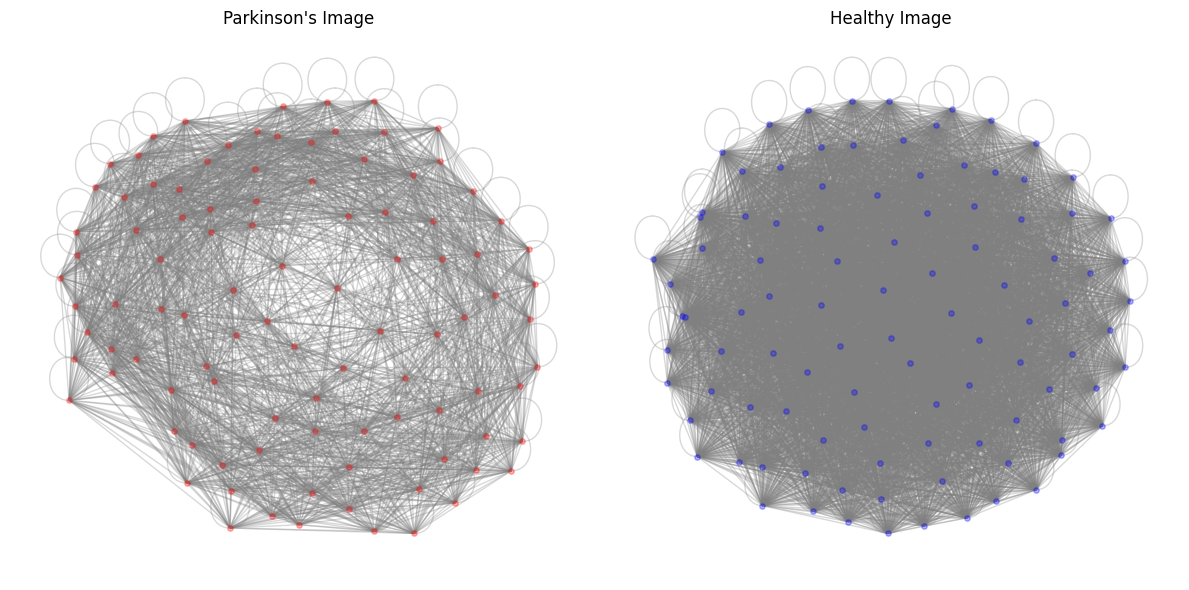

In [10]:
#graph connectivity comparison
# Paths to one Parkinson's image and one normal image
parkinson_image_path = "data/parkinson/Reg_-_sDW_SSh_SENSE_014.png"
normal_image_path = "data/normal/ep2d_diff_3scan_trace_p2_ADC_DFC_005.png"

# Create graphs for the provided images
parkinson_edge_index, parkinson_node_features = image2graph(parkinson_image_path)
normal_edge_index, normal_node_features = image2graph(normal_image_path)

parkinson_data = torch_geometric.data.Data(x=parkinson_node_features, edge_index=parkinson_edge_index)
normal_data = torch_geometric.data.Data(x=normal_node_features, edge_index=normal_edge_index)

parkinson_graph = torch_geometric.utils.to_networkx(parkinson_data, to_undirected=True)
normal_graph = torch_geometric.utils.to_networkx(normal_data, to_undirected=True)

# Visualize the graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Parkinson's Image")
nx.draw(parkinson_graph, with_labels=False, node_size=15, node_color = 'red' , edge_color='gray', alpha=0.3)

plt.subplot(1, 2, 2)
plt.title("Healthy Image")
nx.draw(normal_graph, with_labels=False, node_size=15, node_color = 'blue',  edge_color='gray', alpha=0.3)

plt.tight_layout()
plt.show()


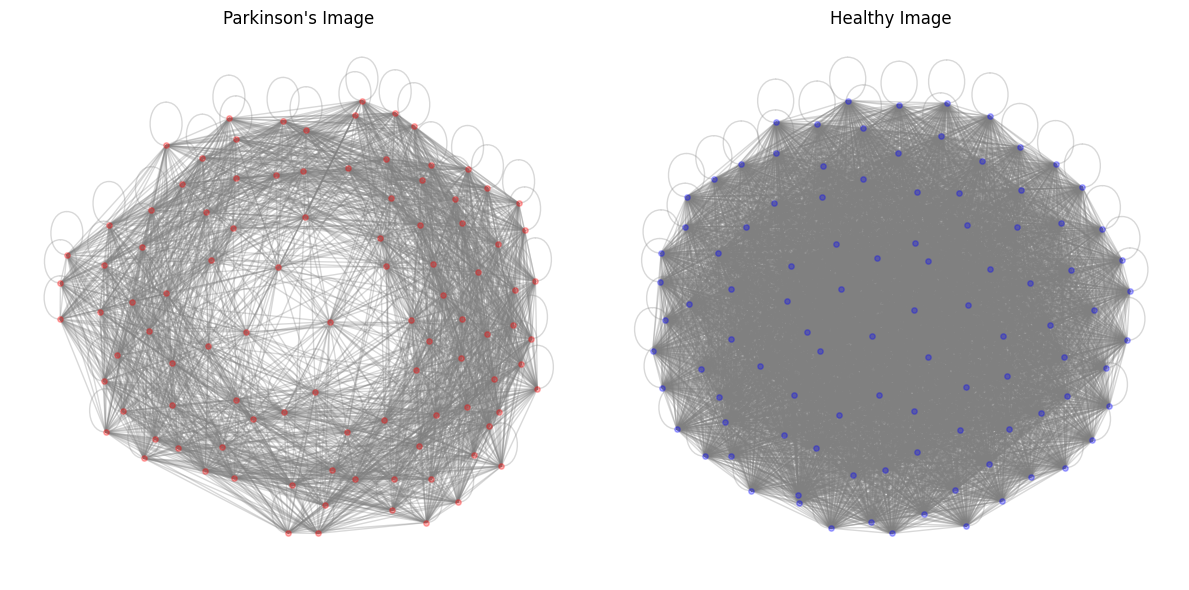

In [11]:
# Paths to one Parkinson's image and one normal image
parkinson_image_path = "data/parkinson/sDW_SSh_036.png"
normal_image_path = "data/normal/localizer_001.png"

# Create graphs for the provided images
parkinson_edge_index, parkinson_node_features = image2graph(parkinson_image_path)
normal_edge_index, normal_node_features = image2graph(normal_image_path)

parkinson_data = torch_geometric.data.Data(x=parkinson_node_features, edge_index=parkinson_edge_index)
normal_data = torch_geometric.data.Data(x=normal_node_features, edge_index=normal_edge_index)

parkinson_graph = torch_geometric.utils.to_networkx(parkinson_data, to_undirected=True)
normal_graph = torch_geometric.utils.to_networkx(normal_data, to_undirected=True)

# Visualize the graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Parkinson's Image")
nx.draw(parkinson_graph, with_labels=False, node_size=15, node_color = 'red' , edge_color='gray', alpha=0.3)

plt.subplot(1, 2, 2)
plt.title("Healthy Image")
nx.draw(normal_graph, with_labels=False, node_size=15, node_color = 'blue',  edge_color='gray', alpha=0.3)

plt.tight_layout()
plt.show()


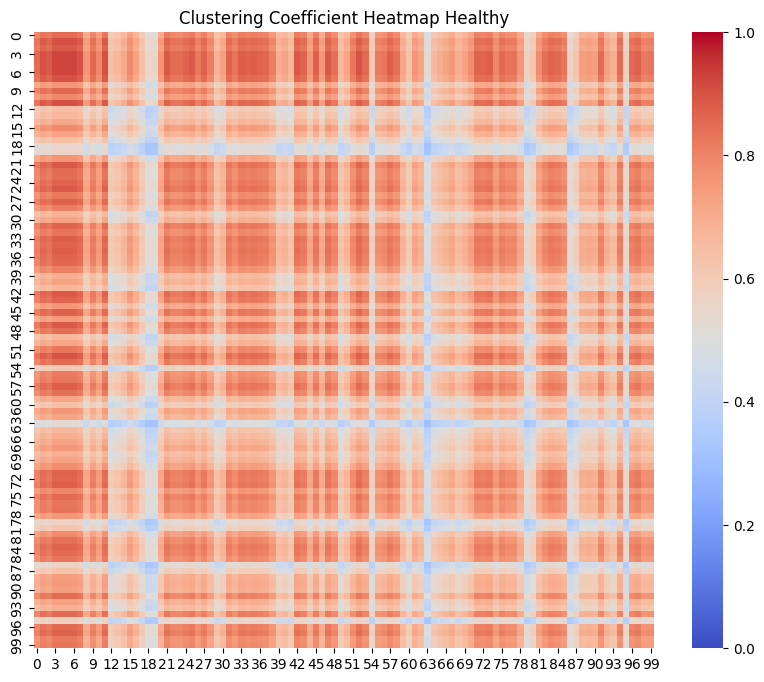

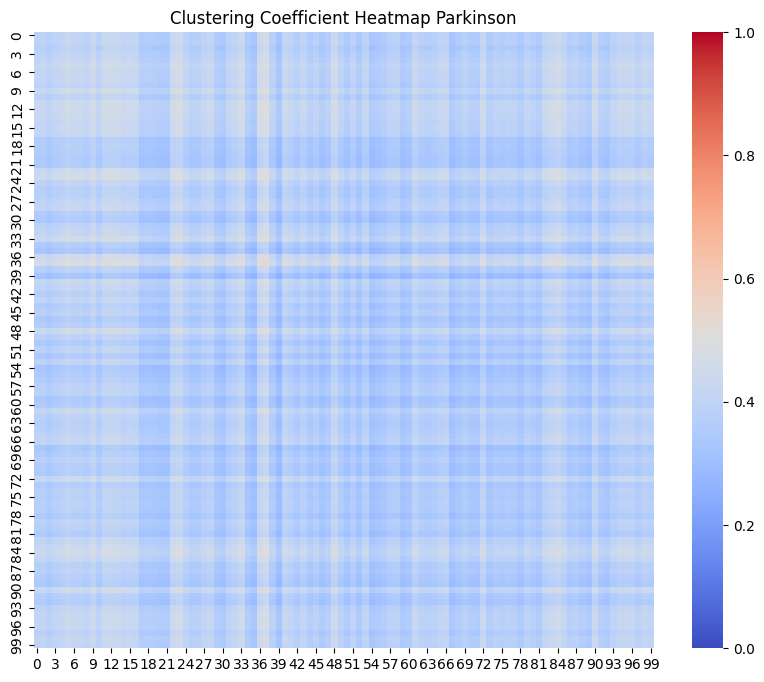

In [12]:
#Heatmap comparison
import networkx as nx

# ...

def get_clustering_coefficients(chunks):
    G = nx.Graph()
    num_nodes = len(chunks)
    G.add_nodes_from(range(num_nodes))

    sum_corr = 0
    num_corr = 0
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            sum_corr += correlation
            num_corr += 1

    avg_corr = sum_corr / num_corr  # Calculate average correlation
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            if correlation >= avg_corr:
                G.add_edge(i, j)

    clustering_coefficients = nx.clustering(G)
    clustering_values = [clustering_coefficients[node] for node in range(num_nodes)]
    return clustering_values

def visualize_clustering_heatmap(img_path , title):
    chunks = create_image_chunks(img_path)
    clustering_values = get_clustering_coefficients(chunks)
    clustering_matrix = np.outer(clustering_values, clustering_values)

    plt.figure(figsize=(10, 8))
    palette = color_palette("coolwarm", as_cmap=True)
    heatmap(clustering_matrix, cmap=palette, vmin=0, vmax=1, annot=False)
    plt.title(title)
    plt.show()

# Example image paths
Normal = 'data/normal/t1_fl3d_sag_p4_iso_1.0_008.png'
Parkinson = 'data/parkinson/sDW_SSh_017.png'

visualize_clustering_heatmap(Normal, "Clustering Coefficient Heatmap Healthy")
visualize_clustering_heatmap(Parkinson, "Clustering Coefficient Heatmap Parkinson")


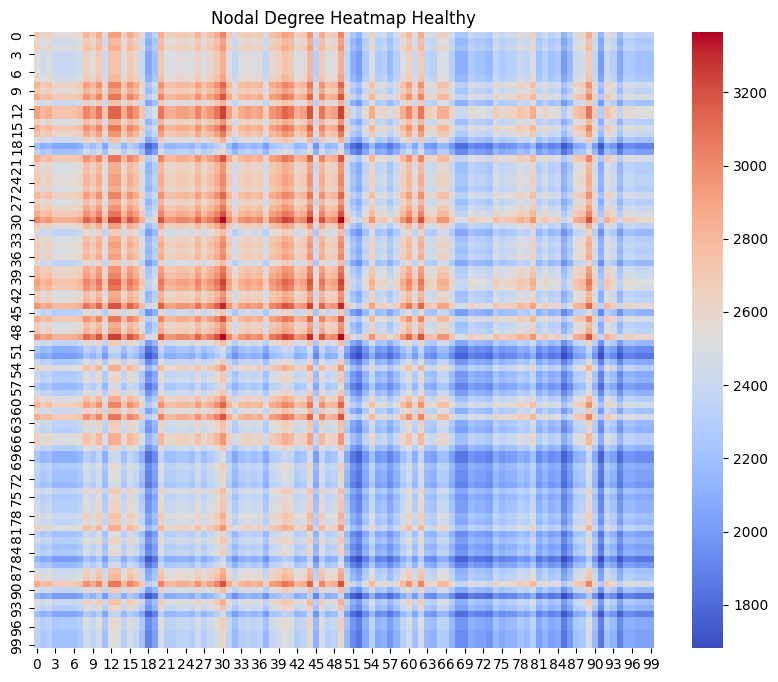

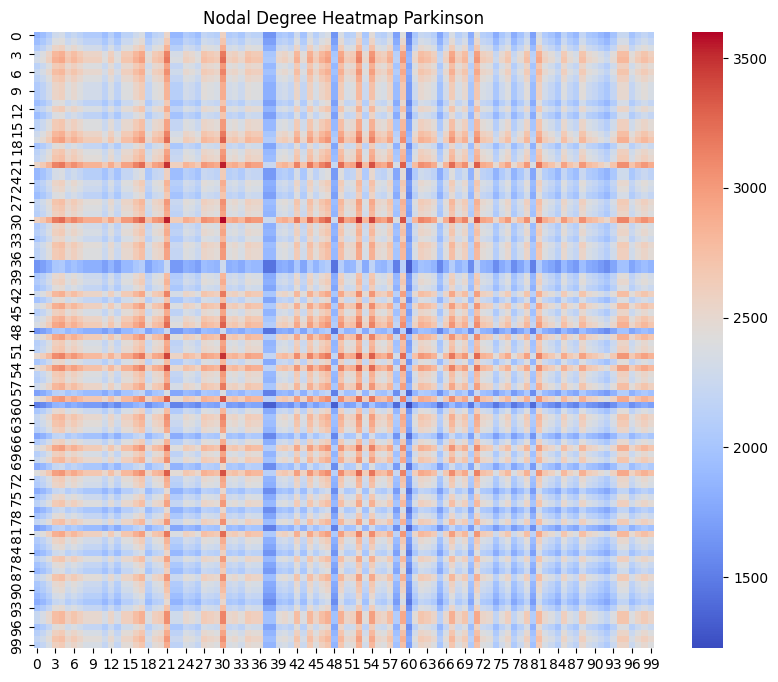

In [13]:
import networkx as nx

# ...

def get_node_degrees(chunks):
    G = nx.Graph()
    num_nodes = len(chunks)
    G.add_nodes_from(range(num_nodes))

    sum_corr = 0
    num_corr = 0
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            sum_corr += correlation
            num_corr += 1

    avg_corr = sum_corr / num_corr  # Calculate average correlation
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            if correlation >= avg_corr:
                G.add_edge(i, j)

    node_degrees = dict(G.degree())
    degree_values = [node_degrees[node] for node in range(num_nodes)]
    return degree_values

def visualize_degree_heatmap(img_path, title):
    chunks = create_image_chunks(img_path)
    degree_values = get_node_degrees(chunks)
    degree_matrix = np.outer(degree_values, degree_values)

    plt.figure(figsize=(10, 8))
    palette = color_palette("coolwarm", as_cmap=True)
    heatmap(degree_matrix, cmap=palette, annot=False)
    plt.title(title)
    plt.show()

# Example image paths
Normal = 'data/normal/t1_fl3d_sag_p4_iso_1.0_008.png'
Parkinson = 'data/parkinson/sDW_SSh_017.png'

visualize_degree_heatmap(Normal, "Nodal Degree Heatmap Healthy")
visualize_degree_heatmap(Parkinson, "Nodal Degree Heatmap Parkinson")


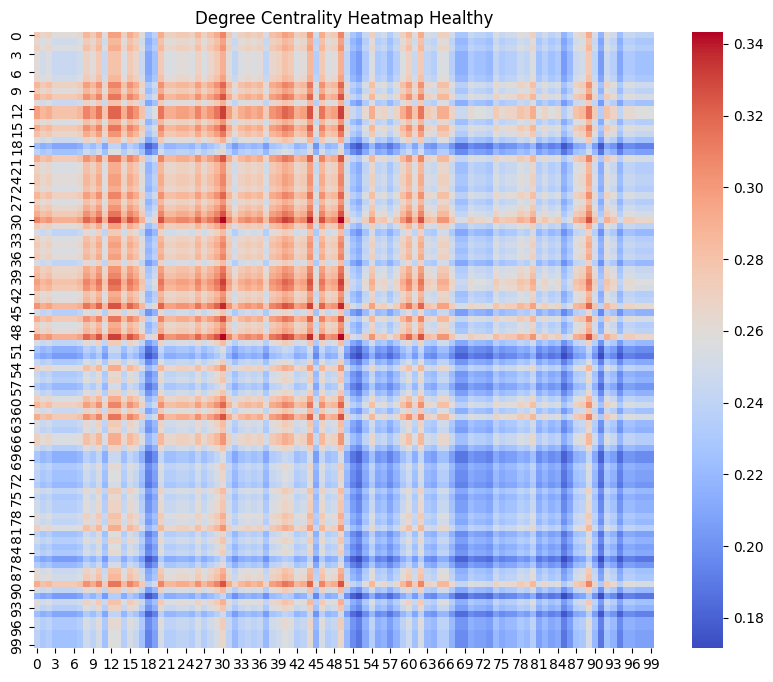

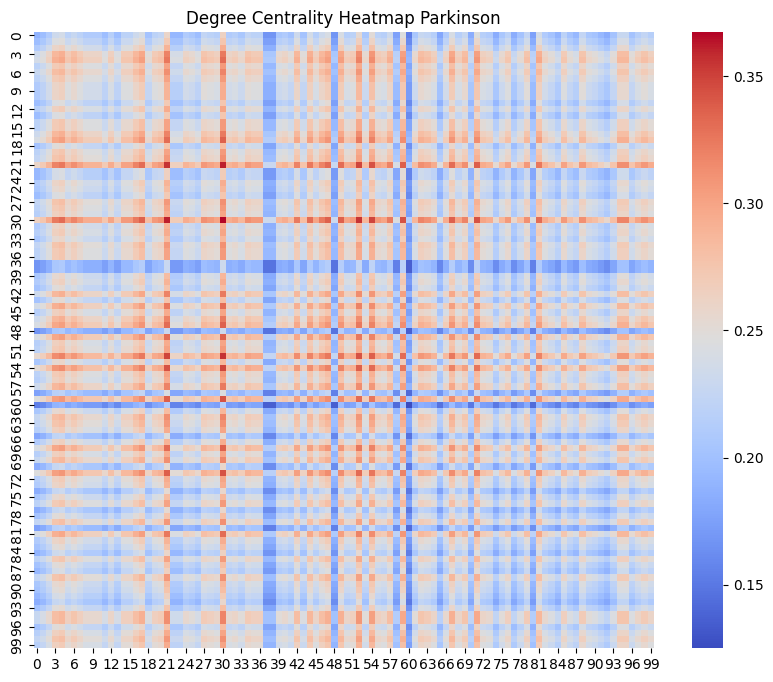

In [14]:
import networkx as nx

# ...

def get_degree_centrality(chunks):
    G = nx.Graph()
    num_nodes = len(chunks)
    G.add_nodes_from(range(num_nodes))

    sum_corr = 0
    num_corr = 0
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            sum_corr += correlation
            num_corr += 1

    avg_corr = sum_corr / num_corr  # Calculate average correlation
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            if correlation >= avg_corr:
                G.add_edge(i, j)

    degree_centrality = nx.degree_centrality(G)
    centrality_values = [degree_centrality[node] for node in range(num_nodes)]
    return centrality_values

def visualize_centrality_heatmap(img_path, title):
    chunks = create_image_chunks(img_path)
    centrality_values = get_degree_centrality(chunks)
    centrality_matrix = np.outer(centrality_values, centrality_values)

    plt.figure(figsize=(10, 8))
    palette = color_palette("coolwarm", as_cmap=True)
    heatmap(centrality_matrix, cmap=palette, annot=False)
    plt.title(title)
    plt.show()

# Example image paths
Normal = 'data/normal/t1_fl3d_sag_p4_iso_1.0_008.png'
Parkinson = 'data/parkinson/sDW_SSh_017.png'

visualize_centrality_heatmap(Normal, "Degree Centrality Heatmap Healthy")
visualize_centrality_heatmap(Parkinson, "Degree Centrality Heatmap Parkinson")
